In [1]:
# copy the weights and configurations for the pre-trained models
!mkdir ~/.keras
!mkdir ~/.keras/models
!cp ../input/keras-pretrained-models/*notop* ~/.keras/models/
!cp ../input/keras-pretrained-models/imagenet_class_index.json ~/.keras/models/

mkdir: cannot create directory ‘/root/.keras’: File exists


In [2]:
!ls ~/.keras/models

imagenet_class_index.json
inception_resnet_v2_weights_tf_dim_ordering_tf_kernels_notop.h5
inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5
resnet50_weights_tf_dim_ordering_tf_kernels_notop.h5
vgg16_weights_tf_dim_ordering_tf_kernels_notop.h5
xception_weights_tf_dim_ordering_tf_kernels_notop.h5


In [ ]:
!ls ../data/datasets/eyepacs/train_11


In [4]:
!unzip ../input/diabetic-retinopathy-detection/trainLabels.csv.zip
!apt install p7zip-full -y
!7z x ../input/diabetic-retinopathy-detection/train.zip.001 "-i!train/11*.jpeg" -y # restrict extracted file to about 100 for the disk restriction
!mkdir data
!mv train data/train_11

Archive:  ../input/diabetic-retinopathy-detection/trainLabels.csv.zip
  inflating: trainLabels.csv         



p7zip-full is already the newest version.
0 upgraded, 0 newly installed, 0 to remove and 0 not upgraded.

7-Zip [64] 9.20  Copyright (c) 1999-2010 Igor Pavlov  2010-11-18
p7zip Version 9.20 (locale=C.UTF-8,Utf16=on,HugeFiles=on,4 CPUs)

Processing archive: ../input/diabetic-retinopathy-detection/train.zip.001

Extracting  train/11003_left.jpeg
Extracting  train/11003_right.jpeg
Extracting  train/11005_left.jpeg
Extracting  train/11005_right.jpeg
Extracting  train/11007_left.jpeg
Extracting  train/11007_right.jpeg
Extracting  train/11008_left.jpeg
Extracting  train/11008_right.jpeg
Extracting  train/1100_left.jpeg
Extracting  train/1100_right.jpeg
Extracting  train/11010_left.jpeg
Extracting  train/11010_right.jpeg
Extracting  train/11013_left.jpeg
Extracting  train/11013_right.jpeg
Extracting  train/11023_left.jpeg
Extracting  train/11023_right.jpeg
Extracting  train/11026_lef

In [5]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt # showing and rendering figures
# io related
from skimage.io import imread
import os
from glob import glob
%matplotlib inline

In [6]:
base_image_dir = os.path.join('/', 'data', 'dataset', 'eyepacs', 'train_11')
retina_df = pd.read_csv('../data/datasets/eyepacs/trainLabels.csv')
retina_df['PatientId'] = retina_df['image'].map(lambda x: x.split('_')[0])
retina_df['path'] = retina_df['image'].map(lambda x: os.path.join(base_image_dir,
                                                         '{}.jpeg'.format(x)))
retina_df['exists'] = retina_df['path'].map(os.path.exists)
print(retina_df['exists'].sum(), 'images found of', retina_df.shape[0], 'total')
retina_df['eye'] = retina_df['image'].map(lambda x: 1 if x.split('_')[-1]=='left' else 0)
from keras.utils.np_utils import to_categorical
retina_df['level_cat'] = retina_df['level'].map(lambda x: to_categorical(x, 1+retina_df['level'].max()))

retina_df.dropna(inplace = True)
retina_df = retina_df[retina_df['exists']]
retina_df.sample(3)

872 images found of 35126 total


/opt/conda/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


image  level PatientId  \
9201  11551_right      0     11551   
9284   11661_left      2     11661   
8978   11263_left      1     11263   

                                                path  exists  eye  \
9201  /kaggle/working/data/train_11/11551_right.jpeg    True    0   
9284   /kaggle/working/data/train_11/11661_left.jpeg    True    1   
8978   /kaggle/working/data/train_11/11263_left.jpeg    True    1   

                      level_cat  
9201  [1.0, 0.0, 0.0, 0.0, 0.0]  
9284  [0.0, 0.0, 1.0, 0.0, 0.0]  
8978  [0.0, 1.0, 0.0, 0.0, 0.0]

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7efbe8f5d2b0>,
      dtype=object)

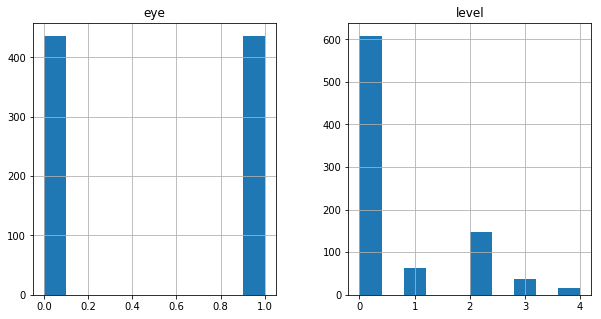

In [7]:
retina_df[['level', 'eye']].hist(figsize = (10, 5))

In [8]:
from sklearn.model_selection import train_test_split
rr_df = retina_df[['PatientId', 'level']].drop_duplicates()
train_ids, valid_ids = train_test_split(rr_df['PatientId'], 
                                   test_size = 0.25, 
                                   random_state = 2018,
                                   stratify = rr_df['level'])
raw_train_df = retina_df[retina_df['PatientId'].isin(train_ids)]
valid_df = retina_df[retina_df['PatientId'].isin(valid_ids)]
print('train', raw_train_df.shape[0], 'validation', valid_df.shape[0])

train 678 validation 242


New Data Size: 750 Old Size: 678


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7efbe8e9b358>,
      dtype=object)

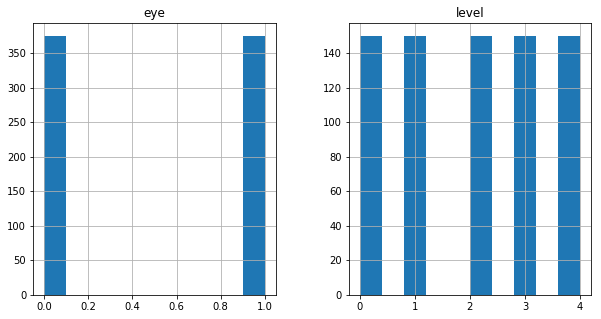

In [9]:
train_df = raw_train_df.groupby(['level', 'eye']).apply(lambda x: x.sample(75, replace = True)
                                                      ).reset_index(drop = True)
print('New Data Size:', train_df.shape[0], 'Old Size:', raw_train_df.shape[0])
train_df[['level', 'eye']].hist(figsize = (10, 5))

In [10]:
import tensorflow as tf
from keras import backend as K
from keras.applications.inception_v3 import preprocess_input
import numpy as np
IMG_SIZE = (512, 512) # slightly smaller than vgg16 normally expects
def tf_image_loader(out_size, 
                      horizontal_flip = True, 
                      vertical_flip = False, 
                     random_brightness = True,
                     random_contrast = True,
                    random_saturation = True,
                    random_hue = True,
                      color_mode = 'rgb',
                       preproc_func = preprocess_input,
                       on_batch = False):
    def _func(X):
        with tf.name_scope('image_augmentation'):
            with tf.name_scope('input'):
                X = tf.image.decode_png(tf.read_file(X), channels = 3 if color_mode == 'rgb' else 0)
                X = tf.image.resize_images(X, out_size)
            with tf.name_scope('augmentation'):
                if horizontal_flip:
                    X = tf.image.random_flip_left_right(X)
                if vertical_flip:
                    X = tf.image.random_flip_up_down(X)
                if random_brightness:
                    X = tf.image.random_brightness(X, max_delta = 0.1)
                if random_saturation:
                    X = tf.image.random_saturation(X, lower = 0.75, upper = 1.5)
                if random_hue:
                    X = tf.image.random_hue(X, max_delta = 0.15)
                if random_contrast:
                    X = tf.image.random_contrast(X, lower = 0.75, upper = 1.5)
                return preproc_func(X)
    if on_batch: 
        # we are meant to use it on a batch
        def _batch_func(X, y):
            return tf.map_fn(_func, X), y
        return _batch_func
    else:
        # we apply it to everything
        def _all_func(X, y):
            return _func(X), y         
        return _all_func
    
def tf_augmentor(out_size,
                intermediate_size = (640, 640),
                 intermediate_trans = 'crop',
                 batch_size = 16,
                   horizontal_flip = True, 
                  vertical_flip = False, 
                 random_brightness = True,
                 random_contrast = True,
                 random_saturation = True,
                    random_hue = True,
                  color_mode = 'rgb',
                   preproc_func = preprocess_input,
                   min_crop_percent = 0.001,
                   max_crop_percent = 0.005,
                   crop_probability = 0.5,
                   rotation_range = 10):
    
    load_ops = tf_image_loader(out_size = intermediate_size, 
                               horizontal_flip=horizontal_flip, 
                               vertical_flip=vertical_flip, 
                               random_brightness = random_brightness,
                               random_contrast = random_contrast,
                               random_saturation = random_saturation,
                               random_hue = random_hue,
                               color_mode = color_mode,
                               preproc_func = preproc_func,
                               on_batch=False)
    def batch_ops(X, y):
        batch_size = tf.shape(X)[0]
        with tf.name_scope('transformation'):
            # code borrowed from https://becominghuman.ai/data-augmentation-on-gpu-in-tensorflow-13d14ecf2b19
            # The list of affine transformations that our image will go under.
            # Every element is Nx8 tensor, where N is a batch size.
            transforms = []
            identity = tf.constant([1, 0, 0, 0, 1, 0, 0, 0], dtype=tf.float32)
            if rotation_range > 0:
                angle_rad = rotation_range / 180 * np.pi
                angles = tf.random_uniform([batch_size], -angle_rad, angle_rad)
                transforms += [tf.contrib.image.angles_to_projective_transforms(angles, intermediate_size[0], intermediate_size[1])]

            if crop_probability > 0:
                crop_pct = tf.random_uniform([batch_size], min_crop_percent, max_crop_percent)
                left = tf.random_uniform([batch_size], 0, intermediate_size[0] * (1.0 - crop_pct))
                top = tf.random_uniform([batch_size], 0, intermediate_size[1] * (1.0 - crop_pct))
                crop_transform = tf.stack([
                      crop_pct,
                      tf.zeros([batch_size]), top,
                      tf.zeros([batch_size]), crop_pct, left,
                      tf.zeros([batch_size]),
                      tf.zeros([batch_size])
                  ], 1)
                coin = tf.less(tf.random_uniform([batch_size], 0, 1.0), crop_probability)
                transforms += [tf.where(coin, crop_transform, tf.tile(tf.expand_dims(identity, 0), [batch_size, 1]))]
            if len(transforms)>0:
                X = tf.contrib.image.transform(X,
                      tf.contrib.image.compose_transforms(*transforms),
                      interpolation='BILINEAR') # or 'NEAREST'
            if intermediate_trans=='scale':
                X = tf.image.resize_images(X, out_size)
            elif intermediate_trans=='crop':
                X = tf.image.resize_image_with_crop_or_pad(X, out_size[0], out_size[1])
            else:
                raise ValueError('Invalid Operation {}'.format(intermediate_trans))
            return X, y
    def _create_pipeline(in_ds):
        batch_ds = in_ds.map(load_ops, num_parallel_calls=4).batch(batch_size)
        return batch_ds.map(batch_ops)
    return _create_pipeline

In [11]:
def flow_from_dataframe(idg, 
                        in_df, 
                        path_col,
                        y_col, 
                        shuffle = True, 
                        color_mode = 'rgb'):
    files_ds = tf.data.Dataset.from_tensor_slices((in_df[path_col].values, 
                                                   np.stack(in_df[y_col].values,0)))
    in_len = in_df[path_col].values.shape[0]
    while True:
        if shuffle:
            files_ds = files_ds.shuffle(in_len) # shuffle the whole dataset
        
        next_batch = idg(files_ds).repeat().make_one_shot_iterator().get_next()
        for i in range(max(in_len//32,1)):
            # NOTE: if we loop here it is 'thread-safe-ish' if we loop on the outside it is completely unsafe
            yield K.get_session().run(next_batch)

In [12]:
batch_size = 48
core_idg = tf_augmentor(out_size = IMG_SIZE, 
                        color_mode = 'rgb', 
                        vertical_flip = True,
                        crop_probability=0.0,
                        batch_size = batch_size) 
valid_idg = tf_augmentor(out_size = IMG_SIZE, color_mode = 'rgb', 
                         crop_probability=0.0, 
                         horizontal_flip = False, 
                         vertical_flip = False, 
                         random_brightness = False,
                         random_contrast = False,
                         random_saturation = False,
                         random_hue = False,
                         rotation_range = 0,
                        batch_size = batch_size)

train_gen = flow_from_dataframe(core_idg, train_df, 
                             path_col = 'path',
                            y_col = 'level_cat')

valid_gen = flow_from_dataframe(valid_idg, valid_df, 
                             path_col = 'path',
                            y_col = 'level_cat') # we can use much larger batches for evaluation

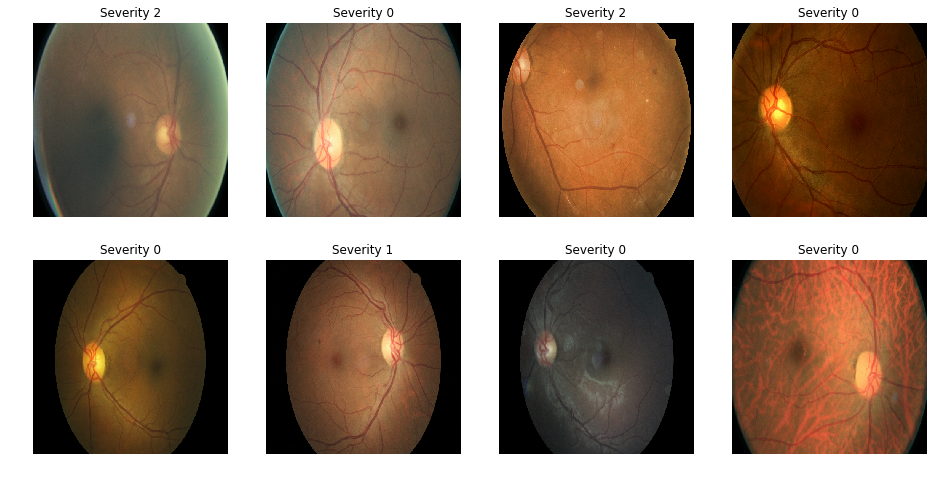

In [13]:
t_x, t_y = next(valid_gen)
fig, m_axs = plt.subplots(2, 4, figsize = (16, 8))
for (c_x, c_y, c_ax) in zip(t_x, t_y, m_axs.flatten()):
    c_ax.imshow(np.clip(c_x*127+127, 0, 255).astype(np.uint8))
    c_ax.set_title('Severity {}'.format(np.argmax(c_y, -1)))
    c_ax.axis('off')

Instructions for updating:
Use the retry module or similar alternatives.


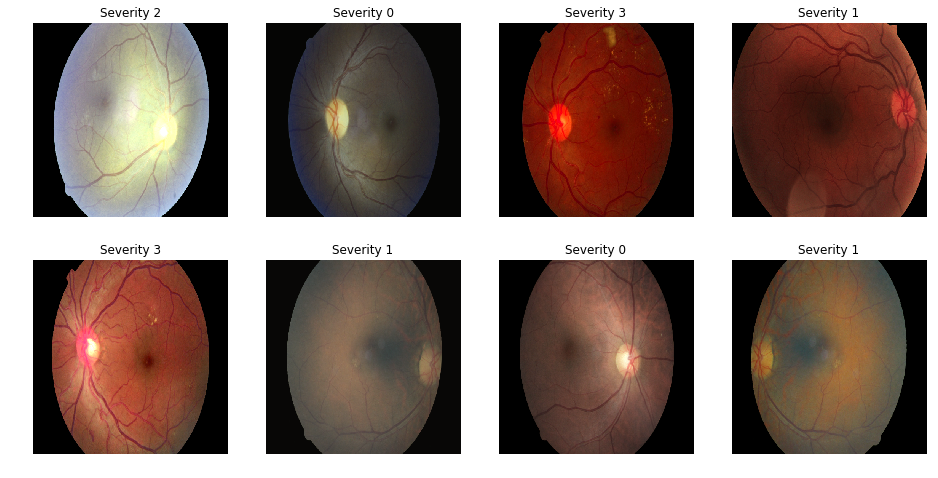

In [14]:
t_x, t_y = next(train_gen)
fig, m_axs = plt.subplots(2, 4, figsize = (16, 8))
for (c_x, c_y, c_ax) in zip(t_x, t_y, m_axs.flatten()):
    c_ax.imshow(np.clip(c_x*127+127, 0, 255).astype(np.uint8))
    c_ax.set_title('Severity {}'.format(np.argmax(c_y, -1)))
    c_ax.axis('off')

In [15]:
from keras.applications.resnet50 import ResNet50 as PTModel

from keras.layers import GlobalAveragePooling2D, Dense, Dropout, Flatten, Input, Conv2D, multiply, LocallyConnected2D, Lambda
from keras.models import Model
in_lay = Input(t_x.shape[1:])
base_pretrained_model = PTModel(input_shape =  t_x.shape[1:], include_top = False, weights = 'imagenet')
base_pretrained_model.trainable = False
pt_depth = base_pretrained_model.get_output_shape_at(0)[-1]
pt_features = base_pretrained_model(in_lay)
from keras.layers import BatchNormalization
bn_features = BatchNormalization()(pt_features)

# here we do an attention mechanism to turn pixels in the GAP on an off

attn_layer = Conv2D(64, kernel_size = (1,1), padding = 'same', activation = 'relu')(Dropout(0.5)(bn_features))
attn_layer = Conv2D(16, kernel_size = (1,1), padding = 'same', activation = 'relu')(attn_layer)
attn_layer = Conv2D(8, kernel_size = (1,1), padding = 'same', activation = 'relu')(attn_layer)
attn_layer = Conv2D(1, 
                    kernel_size = (1,1), 
                    padding = 'valid', 
                    activation = 'sigmoid')(attn_layer)
# fan it out to all of the channels
up_c2_w = np.ones((1, 1, 1, pt_depth))
up_c2 = Conv2D(pt_depth, kernel_size = (1,1), padding = 'same', 
               activation = 'linear', use_bias = False, weights = [up_c2_w])
up_c2.trainable = False
attn_layer = up_c2(attn_layer)

mask_features = multiply([attn_layer, bn_features])
gap_features = GlobalAveragePooling2D()(mask_features)
gap_mask = GlobalAveragePooling2D()(attn_layer)
# to account for missing values from the attention model
gap = Lambda(lambda x: x[0]/x[1], name = 'RescaleGAP')([gap_features, gap_mask])
gap_dr = Dropout(0.25)(gap)
dr_steps = Dropout(0.25)(Dense(128, activation = 'relu')(gap_dr))
out_layer = Dense(t_y.shape[-1], activation = 'softmax')(dr_steps)
retina_model = Model(inputs = [in_lay], outputs = [out_layer])
from keras.metrics import top_k_categorical_accuracy
def top_2_accuracy(in_gt, in_pred):
    return top_k_categorical_accuracy(in_gt, in_pred, k=2)

retina_model.compile(optimizer = 'adam', loss = 'categorical_crossentropy',
                           metrics = ['categorical_accuracy', top_2_accuracy])
retina_model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 512, 512, 3)  0                                            
__________________________________________________________________________________________________
resnet50 (Model)                (None, 2, 2, 2048)   23587712    input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 2, 2, 2048)   8192        resnet50[1][0]                   
__________________________________________________________________________________________________
dropout_1 (Dropout)             (None, 2, 2, 2048)   0           batch_normalization_1[0][0]      
__________________________________________________________________________________________________
conv2d_1 (

In [16]:
from keras.callbacks import ModelCheckpoint, LearningRateScheduler, EarlyStopping, ReduceLROnPlateau
weight_path="{}_weights.best.hdf5".format('retina')

checkpoint = ModelCheckpoint(weight_path, monitor='val_loss', verbose=1, 
                             save_best_only=True, mode='min', save_weights_only = True)

reduceLROnPlat = ReduceLROnPlateau(monitor='val_loss', factor=0.8, patience=3, verbose=1, mode='auto', epsilon=0.0001, cooldown=5, min_lr=0.0001)
early = EarlyStopping(monitor="val_loss", 
                      mode="min", 
                      patience=6)
callbacks_list = [checkpoint, early, reduceLROnPlat]

In [17]:
!rm -rf ~/.keras # clean up before starting training

In [18]:
retina_model.fit_generator(train_gen, 
                           steps_per_epoch = train_df.shape[0]//batch_size,
                           validation_data = valid_gen, 
                           validation_steps = valid_df.shape[0]//batch_size,
                              epochs = 2, 
                              callbacks = callbacks_list,
                             workers = 0, # tf-generators are not thread-safe
                             use_multiprocessing=False, 
                             max_queue_size = 0
                            )

Epoch 1/2
15/15 [==============================] - 77s 5s/step - loss: 1.5611 - categorical_accuracy: 0.3696 - top_2_accuracy: 0.5883 - val_loss: 2.6956 - val_categorical_accuracy: 0.1907 - val_top_2_accuracy: 0.8402

Epoch 00001: val_loss improved from inf to 2.69562, saving model to retina_weights.best.hdf5
Epoch 2/2
15/15 [==============================] - 73s 5s/step - loss: 1.0848 - categorical_accuracy: 0.5597 - top_2_accuracy: 0.7944 - val_loss: 2.3733 - val_categorical_accuracy: 0.1958 - val_top_2_accuracy: 0.8292

Epoch 00002: val_loss improved from 2.69562 to 2.37327, saving model to retina_weights.best.hdf5


In [19]:
# load the best version of the model
retina_model.load_weights(weight_path)
retina_model.save('full_retina_model.h5')

In [20]:
##### create one fixed dataset for evaluating
from tqdm import tqdm_notebook
# fresh valid gen
valid_gen = flow_from_dataframe(valid_idg, valid_df, 
                             path_col = 'path',
                            y_col = 'level_cat') 
vbatch_count = (valid_df.shape[0]//batch_size-1)
out_size = vbatch_count*batch_size
test_X = np.zeros((out_size,)+t_x.shape[1:], dtype = np.float32)
test_Y = np.zeros((out_size,)+t_y.shape[1:], dtype = np.float32)
for i, (c_x, c_y) in zip(tqdm_notebook(range(vbatch_count)), 
                         valid_gen):
    j = i*batch_size
    test_X[j:(j+c_x.shape[0])] = c_x
    test_Y[j:(j+c_x.shape[0])] = c_y

HBox(children=(IntProgress(value=0, max=4), HTML(value='')))

In [21]:
# get the attention layer since it is the only one with a single output dim
for attn_layer in retina_model.layers:
    c_shape = attn_layer.get_output_shape_at(0)
    if len(c_shape)==4:
        if c_shape[-1]==1:
            print(attn_layer)
            break

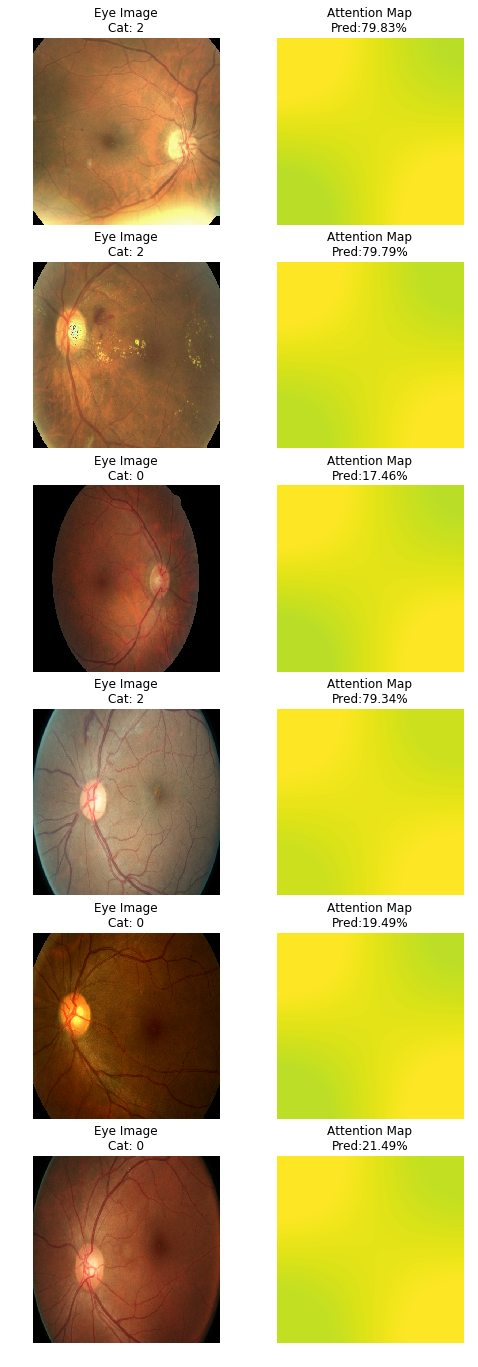

In [22]:
import keras.backend as K
rand_idx = np.random.choice(range(len(test_X)), size = 6)
attn_func = K.function(inputs = [retina_model.get_input_at(0), K.learning_phase()],
           outputs = [attn_layer.get_output_at(0)]
          )
fig, m_axs = plt.subplots(len(rand_idx), 2, figsize = (8, 4*len(rand_idx)))
[c_ax.axis('off') for c_ax in m_axs.flatten()]
for c_idx, (img_ax, attn_ax) in zip(rand_idx, m_axs):
    cur_img = test_X[c_idx:(c_idx+1)]
    attn_img = attn_func([cur_img, 0])[0]
    img_ax.imshow(np.clip(cur_img[0,:,:,:]*127+127, 0, 255).astype(np.uint8))
    attn_ax.imshow(attn_img[0, :, :, 0]/attn_img[0, :, :, 0].max(), cmap = 'viridis', 
                   vmin = 0, vmax = 1, 
                   interpolation = 'lanczos')
    real_cat = np.argmax(test_Y[c_idx, :])
    img_ax.set_title('Eye Image\nCat:%2d' % (real_cat))
    pred_cat = retina_model.predict(cur_img)
    attn_ax.set_title('Attention Map\nPred:%2.2f%%' % (100*pred_cat[0,real_cat]))
fig.savefig('attention_map.png', dpi = 300)

Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to /root/.torch/models/resnet50-19c8e357.pth
100%|██████████| 102502400/102502400 [00:00<00:00, 136305717.81it/s]


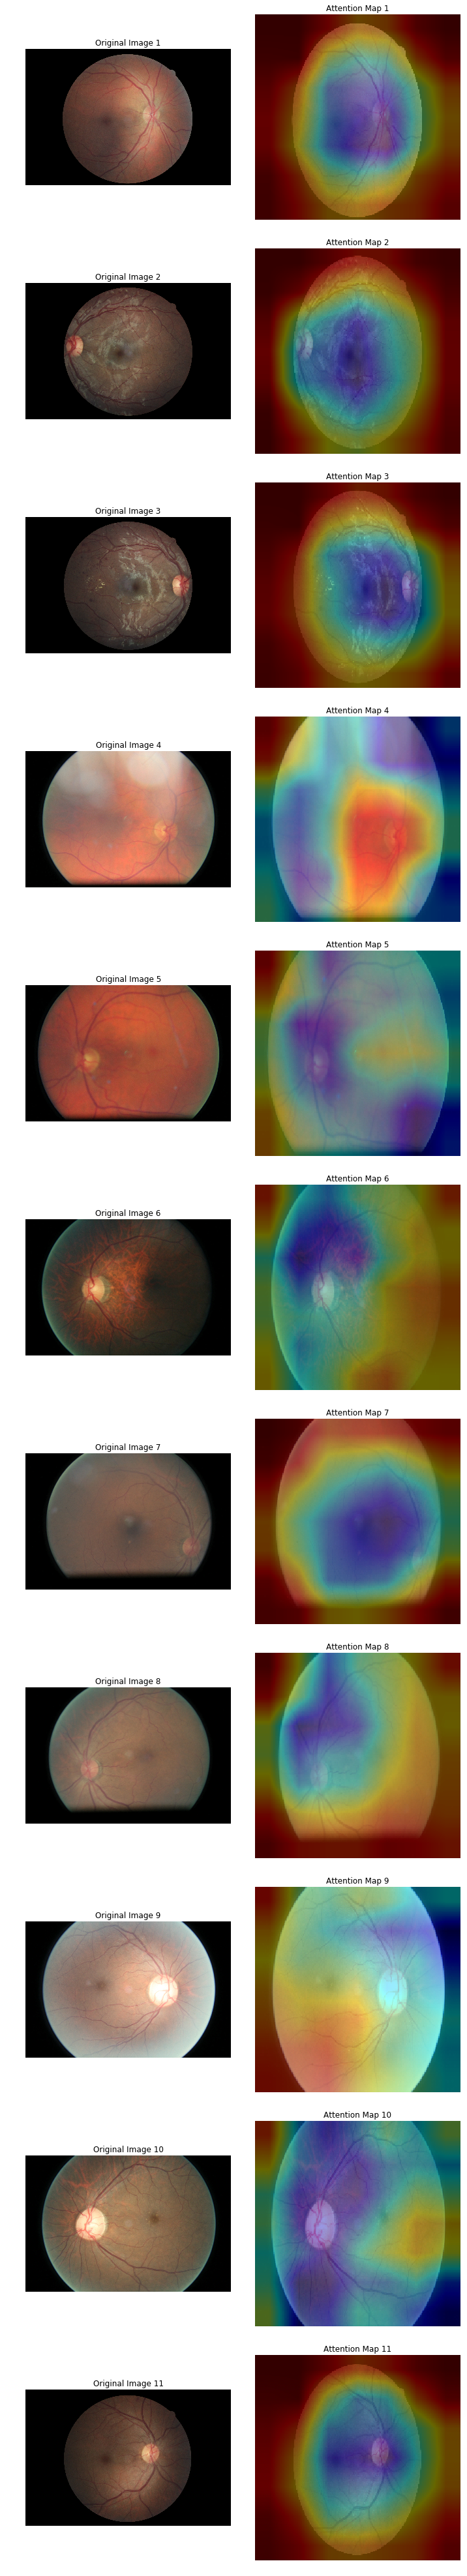

In [23]:
import cv2
import numpy as np
import torch
import torch.nn.functional as F
from torchvision import models, transforms
import matplotlib.pyplot as plt

# List of image paths
image_paths = [
    '../data/datasets/eyepacs/train_11/11779_right.jpeg', '../data/datasets/eyepacs/train_11/1177_left.jpeg',
    '../data/datasets/eyepacs/train_11/1177_right.jpeg', '../data/datasets/eyepacs/train_11/11780_left.jpeg',
    '../data/datasets/eyepacs/train_11/11780_right.jpeg', '../data/datasets/eyepacs/train_11/11781_left.jpeg',
    '../data/datasets/eyepacs/train_11/11786_left.jpeg',
    '../data/datasets/eyepacs/train_11/11786_right.jpeg', '../data/datasets/eyepacs/train_11/11789_left.jpeg',
    '../data/datasets/eyepacs/train_11/11789_right.jpeg',
    '../data/datasets/eyepacs/train_11/1178_right.jpeg'
]

# Step 2: Preprocess the Image
preprocess = transforms.Compose([
    transforms.ToPILImage(),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

# Step 3: Load Pre-trained Model and Set to Evaluation Mode
model = models.resnet50(pretrained=True)
model.eval()

# Step 4: Define Grad-CAM Function
class GradCAM:
    def __init__(self, model, target_layer):
        self.model = model
        self.target_layer = target_layer
        self.gradients = None
        self.activations = None
        self.hook_layers()

    def hook_layers(self):
        def forward_hook(module, input, output):
            self.activations = output.detach()

        def backward_hook(module, grad_in, grad_out):
            self.gradients = grad_out[0].detach()

        target_layer = dict(self.model.named_modules())[self.target_layer]
        target_layer.register_forward_hook(forward_hook)
        target_layer.register_backward_hook(backward_hook)

    def generate_heatmap(self, input_tensor, class_index=None):
        # Forward pass
        output = self.model(input_tensor)

        # Convert output to Tensor if it's not already
        if isinstance(output, torch.Tensor):
            output = output
        else:
            output = output.data  # Handle old versions of PyTorch

        if class_index is None:
            # Ensure output is a tensor and use max(1) to get the class index
            class_index = output.max(1)[1].item()

        score = output[:, class_index]

        # Backward pass
        self.model.zero_grad()
        score.backward()

        # Calculate Grad-CAM
        weights = self.gradients.mean(dim=2, keepdim=True)  # Fix: Use dim=2 for channel dimension
        cam = (weights * self.activations).sum(dim=1)[0]  # Summing across channels (dim=1)
        cam = F.relu(cam)  # Apply ReLU to keep positive values
        cam = cam / cam.max()  # Normalize

        # Resize to match original image size
        cam = cv2.resize(cam.cpu().numpy(), (224, 224))
        return cam

# Initialize GradCAM with the target layer
grad_cam = GradCAM(model=model, target_layer='layer4')

# Step 5: Loop through each image and display results
fig, axs = plt.subplots(len(image_paths), 2, figsize=(10, 5 * len(image_paths)))

for i, image_path in enumerate(image_paths):
    # Load and preprocess each image
    image = cv2.imread(image_path)
    if image is None:
        print(f"Image not found at path: {image_path}")
        continue
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    original_image = image.copy()
    image = cv2.resize(image, (224, 224))
    input_tensor = preprocess(image).unsqueeze(0)  # Add batch dimension

    # Generate Grad-CAM heatmap
    heatmap = grad_cam.generate_heatmap(input_tensor)
    heatmap = cv2.applyColorMap(np.uint8(255 * heatmap), cv2.COLORMAP_JET)
    overlay = cv2.addWeighted(image, 0.6, heatmap, 0.4, 0)

    # Display original and Grad-CAM overlay side-by-side
    axs[i, 0].imshow(original_image)
    axs[i, 0].set_title(f'Original Image {i+1}')
    axs[i, 0].axis('off')

    axs[i, 1].imshow(overlay)
    axs[i, 1].set_title(f'Attention Map {i+1}')
    axs[i, 1].axis('off')

plt.tight_layout()
plt.show()

In [24]:
from sklearn.metrics import accuracy_score, classification_report
pred_Y = retina_model.predict(test_X, batch_size = 32, verbose = True)
pred_Y_cat = np.argmax(pred_Y, -1)
test_Y_cat = np.argmax(test_Y, -1)
print('Accuracy on Test Data: %2.2f%%' % (accuracy_score(test_Y_cat, pred_Y_cat)))
print(classification_report(test_Y_cat, pred_Y_cat))

192/192 [==============================] - 4s 21ms/step
Accuracy on Test Data: 0.18%
             precision    recall  f1-score   support

          0       0.00      0.00      0.00       128
          1       0.00      0.00      0.00        15
          2       0.18      1.00      0.30        34
          3       0.00      0.00      0.00        11
          4       0.00      0.00      0.00         4

avg / total       0.03      0.18      0.05       192



/opt/conda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


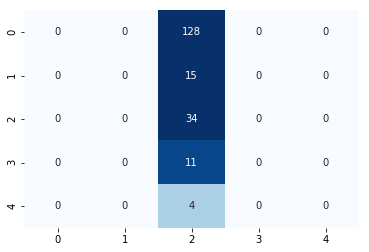

In [25]:
import seaborn as sns
from sklearn.metrics import confusion_matrix
sns.heatmap(confusion_matrix(test_Y_cat, pred_Y_cat), 
            annot=True, fmt="d", cbar = False, cmap = plt.cm.Blues, vmax = test_X.shape[0]//16)

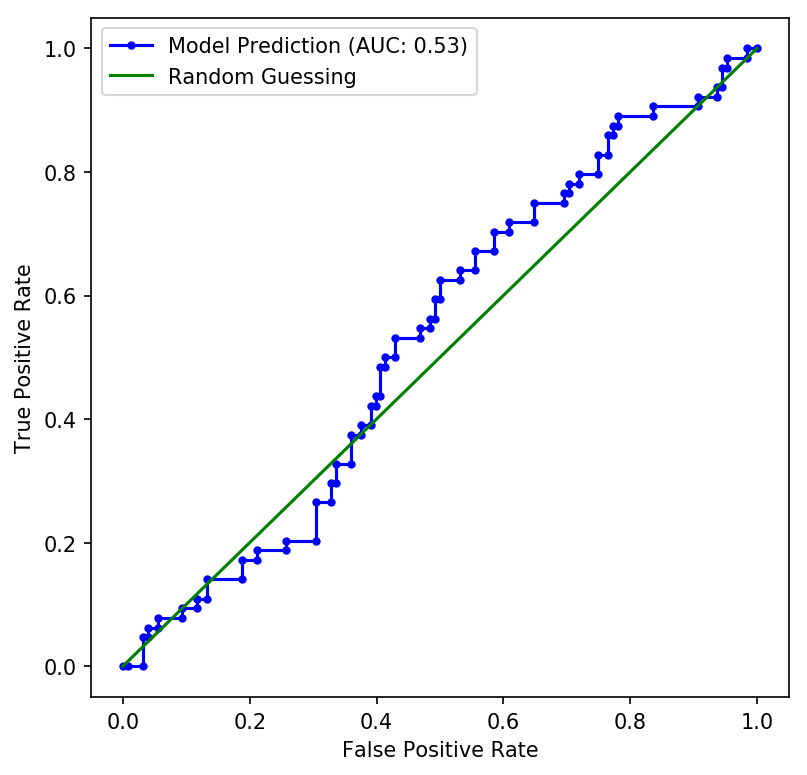

In [26]:

from sklearn.metrics import roc_curve, roc_auc_score
sick_vec = test_Y_cat>0
sick_score = np.sum(pred_Y[:,1:],1)
fpr, tpr, _ = roc_curve(sick_vec, sick_score)
fig, ax1 = plt.subplots(1,1, figsize = (6, 6), dpi = 150)
ax1.plot(fpr, tpr, 'b.-', label = 'Model Prediction (AUC: %2.2f)' % roc_auc_score(sick_vec, sick_score))
ax1.plot(fpr, fpr, 'g-', label = 'Random Guessing')
ax1.legend()
ax1.set_xlabel('False Positive Rate')
ax1.set_ylabel('True Positive Rate');

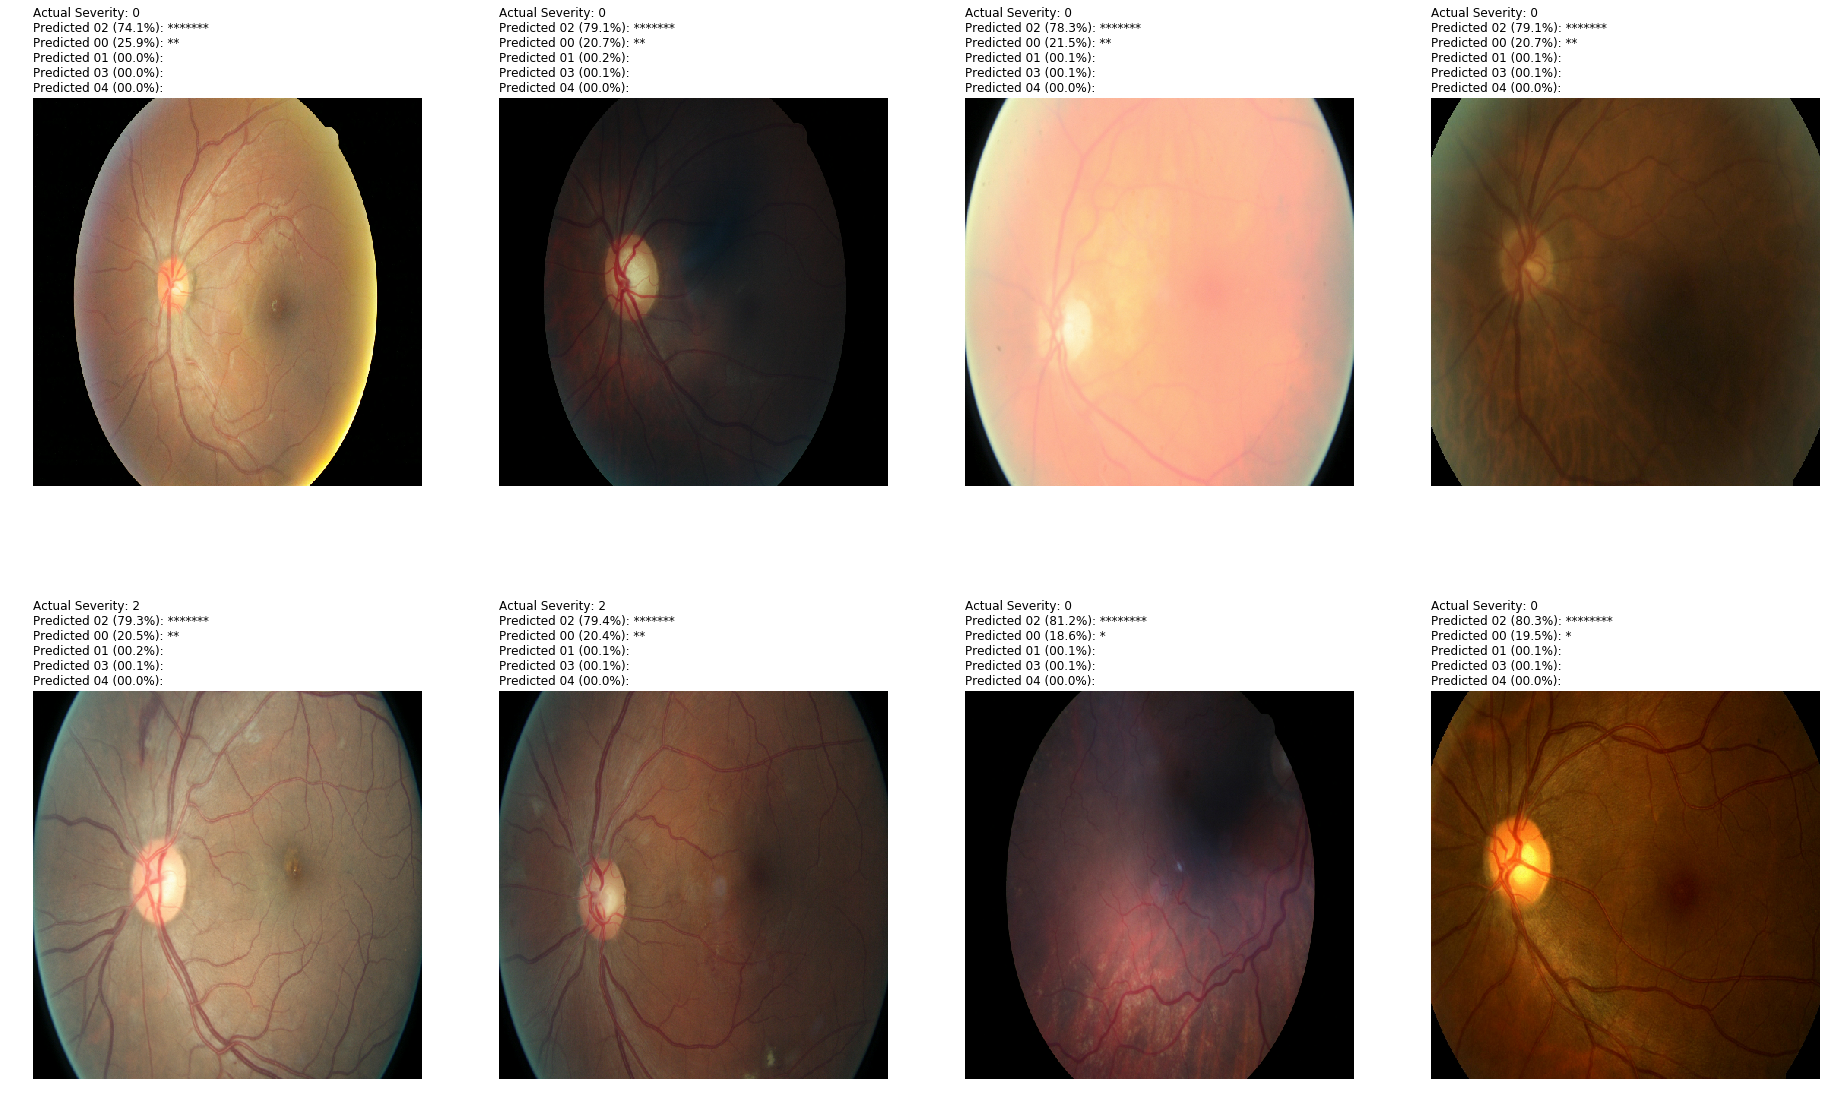

In [27]:
fig, m_axs = plt.subplots(2, 4, figsize = (32, 20))
for (idx, c_ax) in enumerate(m_axs.flatten()):
    c_ax.imshow(np.clip(test_X[idx]*127+127,0 , 255).astype(np.uint8), cmap = 'bone')
    c_ax.set_title('Actual Severity: {}\n{}'.format(test_Y_cat[idx], 
                                                           '\n'.join(['Predicted %02d (%04.1f%%): %s' % (k, 100*v, '*'*int(10*v)) for k, v in sorted(enumerate(pred_Y[idx]), key = lambda x: -1*x[1])])), loc='left')
    c_ax.axis('off')
fig.savefig('trained_img_predictions.png', dpi = 300)

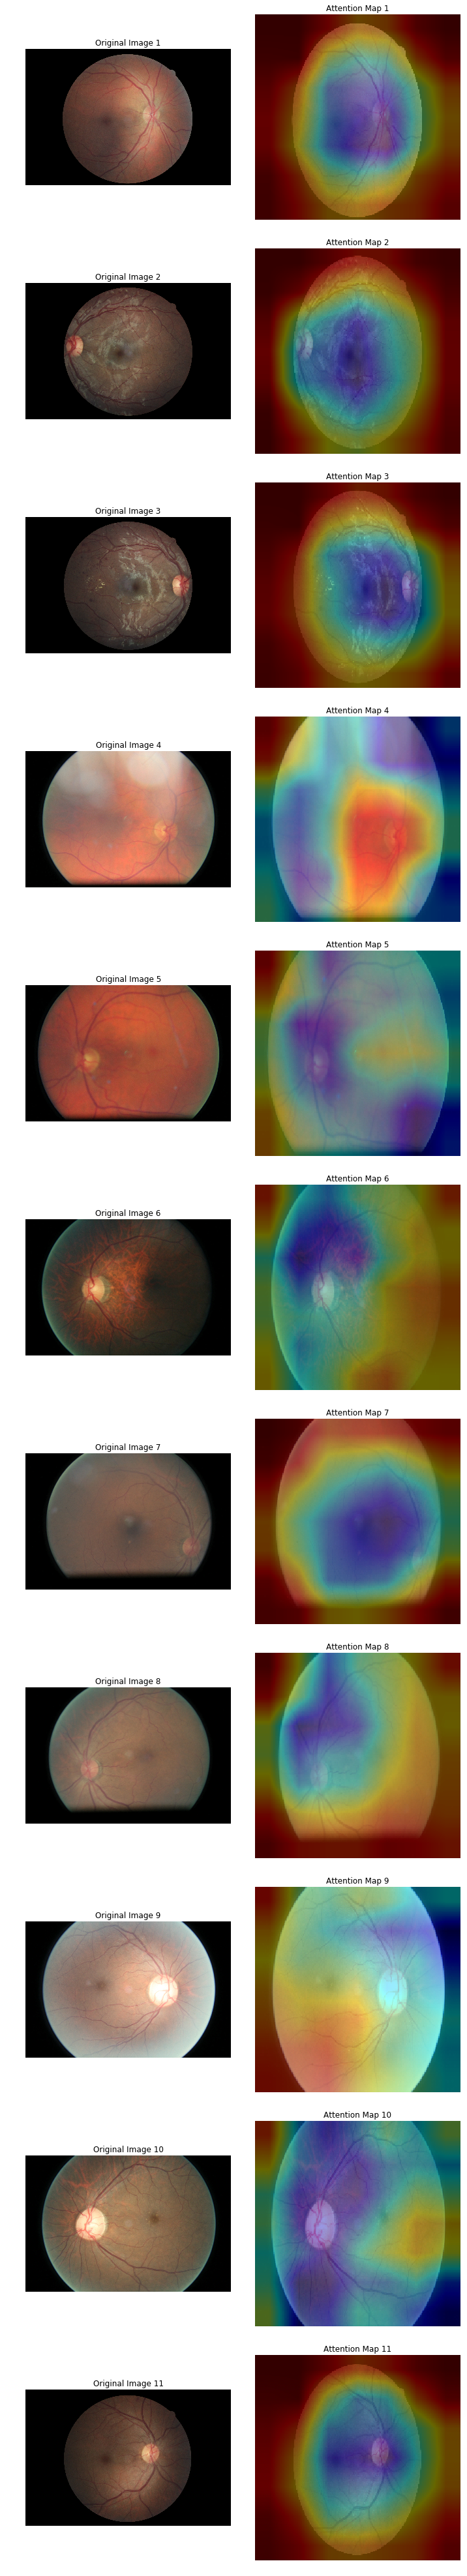

In [28]:
import cv2
import numpy as np
import torch
import torch.nn.functional as F
from torchvision import models, transforms
import matplotlib.pyplot as plt

# List of image paths
image_paths = [
    '../data/datasets/eyepacs/train_11/11779_right.jpeg', '../data/datasets/eyepacs/train_11/1177_left.jpeg',
    '../data/datasets/eyepacs/train_11/1177_right.jpeg', '../data/datasets/eyepacs/train_11/11780_left.jpeg',
    '../data/datasets/eyepacs/train_11/11780_right.jpeg', '../data/datasets/eyepacs/train_11/11781_left.jpeg',
    '../data/datasets/eyepacs/train_11/11786_left.jpeg',
    '../data/datasets/eyepacs/train_11/11786_right.jpeg', '../data/datasets/eyepacs/train_11/11789_left.jpeg',
    '../data/datasets/eyepacs/train_11/11789_right.jpeg', 
    '../data/datasets/eyepacs/train_11/1178_right.jpeg'
]

# Step 2: Preprocess the Image
preprocess = transforms.Compose([
    transforms.ToPILImage(),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

# Step 3: Load Pre-trained Model and Set to Evaluation Mode
model = models.resnet50(pretrained=True)
model.eval()

# Step 4: Define Grad-CAM Function
class GradCAM:
    def __init__(self, model, target_layer):
        self.model = model
        self.target_layer = target_layer
        self.gradients = None
        self.activations = None
        self.hook_layers()

    def hook_layers(self):
        def forward_hook(module, input, output):
            self.activations = output.detach()

        def backward_hook(module, grad_in, grad_out):
            self.gradients = grad_out[0].detach()

        target_layer = dict(self.model.named_modules())[self.target_layer]
        target_layer.register_forward_hook(forward_hook)
        target_layer.register_backward_hook(backward_hook)

    def generate_heatmap(self, input_tensor, class_index=None):
        # Forward pass
        output = self.model(input_tensor)

        # Convert output to Tensor if it's not already
        if isinstance(output, torch.Tensor):
            output = output
        else:
            output = output.data  # Handle old versions of PyTorch

        if class_index is None:
            # Ensure output is a tensor and use max(1) to get the class index
            class_index = output.max(1)[1].item()

        score = output[:, class_index]

        # Backward pass
        self.model.zero_grad()
        score.backward()

        # Calculate Grad-CAM
        weights = self.gradients.mean(dim=2, keepdim=True)  # Fix: Use dim=2 for channel dimension
        cam = (weights * self.activations).sum(dim=1)[0]  # Summing across channels (dim=1)
        cam = F.relu(cam)  # Apply ReLU to keep positive values
        cam = cam / cam.max()  # Normalize

        # Resize to match original image size
        cam = cv2.resize(cam.cpu().numpy(), (224, 224))
        return cam

# Initialize GradCAM with the target layer
grad_cam = GradCAM(model=model, target_layer='layer4')

# Step 5: Loop through each image and display results
fig, axs = plt.subplots(len(image_paths), 2, figsize=(10, 5 * len(image_paths)))

for i, image_path in enumerate(image_paths):
    # Load and preprocess each image
    image = cv2.imread(image_path)
    if image is None:
        print(f"Image not found at path: {image_path}")
        continue
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    original_image = image.copy()
    image = cv2.resize(image, (224, 224))
    input_tensor = preprocess(image).unsqueeze(0)  # Add batch dimension

    # Generate Grad-CAM heatmap
    heatmap = grad_cam.generate_heatmap(input_tensor)
    heatmap = cv2.applyColorMap(np.uint8(255 * heatmap), cv2.COLORMAP_JET)
    overlay = cv2.addWeighted(image, 0.6, heatmap, 0.4, 0)

    # Display original and Grad-CAM overlay side-by-side
    axs[i, 0].imshow(original_image)
    axs[i, 0].set_title(f'Original Image {i+1}')
    axs[i, 0].axis('off')

    axs[i, 1].imshow(overlay)
    axs[i, 1].set_title(f'Attention Map {i+1}')
    axs[i, 1].axis('off')

plt.tight_layout()
plt.show()
